In [2]:
import numpy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

y, sr = librosa.load('./recorded/output.wav')
ipd.Audio(y, rate=sr)

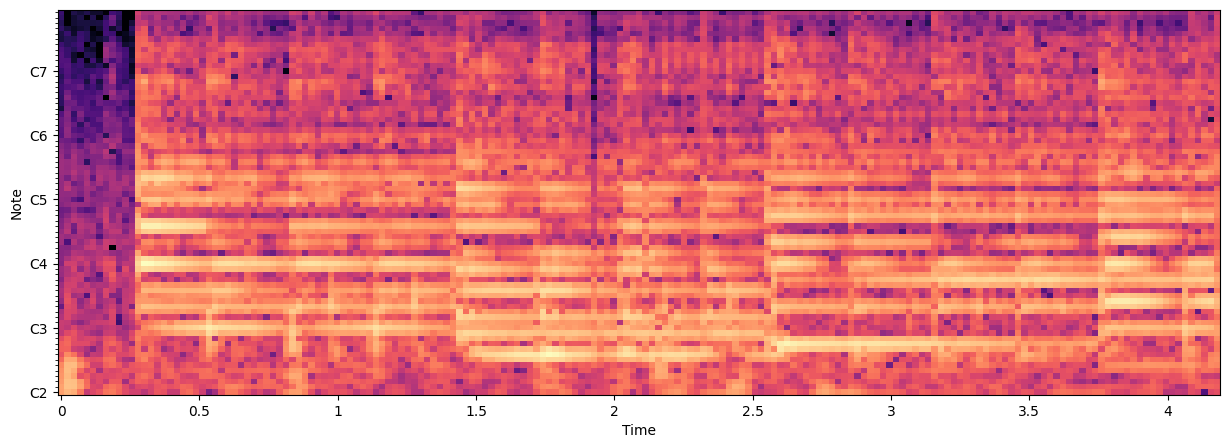

In [3]:
HOP_LENGTH = 1024
F_MIN = librosa.midi_to_hz(36)
C = librosa.cqt(y, sr=sr, fmin=F_MIN, n_bins=72, hop_length=HOP_LENGTH)

logC = librosa.amplitude_to_db(numpy.abs(C))
plt.figure(figsize=(15, 5))
librosa.display.specshow(logC, sr=sr, x_axis='time', y_axis='cqt_note', fmin=F_MIN)

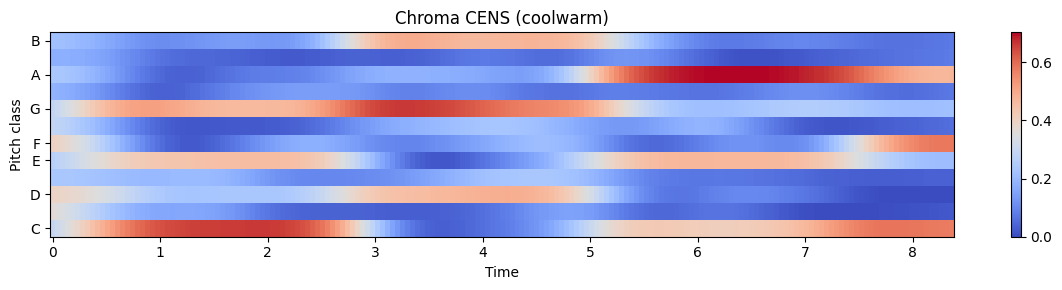

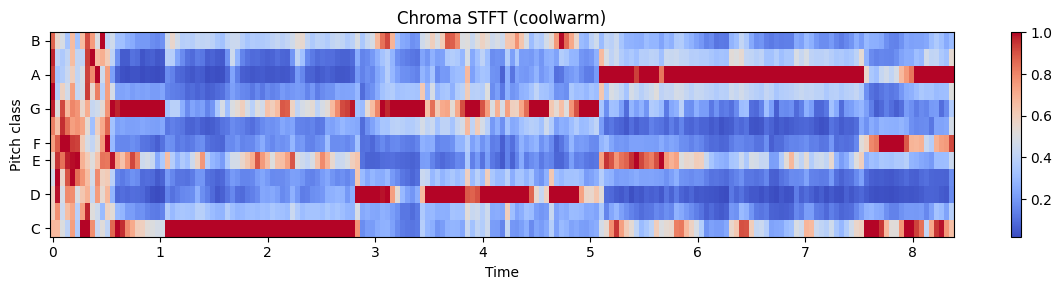

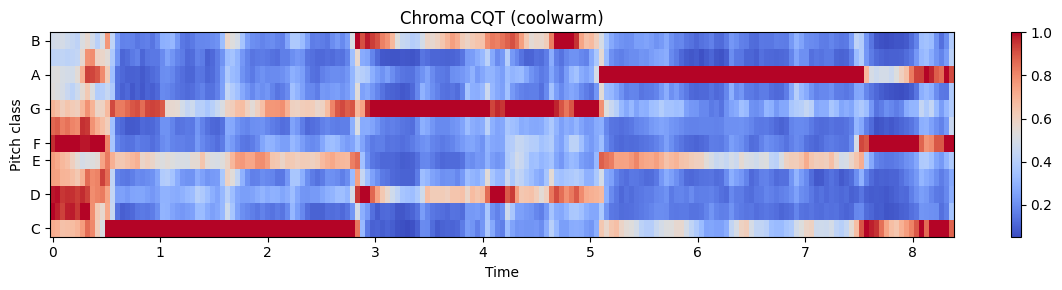

In [4]:
def plot_chroma(chorma, name, cmap='coolwarm'):
    plt.figure(figsize=(12, 3))
    librosa.display.specshow(chorma, x_axis='time', y_axis='chroma', hop_length=HOP_LENGTH, cmap=cmap)
    plt.colorbar()
    plt.title(f'Chroma {name} ({cmap})')
    plt.tight_layout()
    plt.show()

chroma_cens = librosa.feature.chroma_cens(y=y, sr=sr, hop_length=HOP_LENGTH)
plot_chroma(chroma_cens, 'CENS')

chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, hop_length=HOP_LENGTH)
plot_chroma(chroma_stft, 'STFT')

chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=HOP_LENGTH)
plot_chroma(chroma_cqt, 'CQT')




In [5]:
import numpy as np
from src.features_recognizer import FeaturesRecognizer

templates, chords = FeaturesRecognizer.get_chord_templates()

# Compute the chroma features
chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=HOP_LENGTH)

# Match chroma vectors to chord templates
def match_chord(chroma_frame):
    similarities = templates @ chroma_frame
    match = np.argmax(similarities)

    return chords[match]

# Get timestamps
timestamps = librosa.frames_to_time(np.arange(chroma.shape[1]), sr=sr, hop_length=HOP_LENGTH)

# Estimate chords with timestamps
chords_with_timestamps = [
    f"Chord: {match_chord(chroma[:, t])}, time: {timestamps[t]:.2f}s."
    for t in range(0, chroma.shape[1], 20)
]

print(('\n').join(chords_with_timestamps))


Chord: D, time: 0.00s.
Chord: C, time: 0.93s.
Chord: C, time: 1.86s.
Chord: C, time: 2.79s.
Chord: G, time: 3.72s.
Chord: G, time: 4.64s.
Chord: Am, time: 5.57s.
Chord: Am, time: 6.50s.
Chord: Am, time: 7.43s.
Chord: F, time: 8.36s.


In [1]:
import sys
from src.chords_detection import ChordsAnalizer
from src.features_recognizer import FeaturesRecognizer


BUFF_SIZE = 1024 * 8  # Increased buffer size
CHANNELS = 1 if sys.platform == "darwin" else 2
SAMPLE_RATE = 44100

user_name = 'test_user'
record_name = input('Please specify the record name.')

with open(f'./streamed_chords/{record_name}.csv', 'w+', encoding='utf-8') as csv_output:
    chords_recognizer = FeaturesRecognizer(hop_length=256)
    chords_analyzer = ChordsAnalizer(chords_recognizer, BUFF_SIZE, CHANNELS, SAMPLE_RATE)
    try:
        chords_analyzer.record_chords(csv_output, user_name, record_name)
    except KeyboardInterrupt:
        output_path = chords_analyzer.stop_audio_stream()
        print('Saved to:', csv_output.name)
        
        
final_chroma = chords_analyzer.build_final_chroma(output_path)


Detecting chords:
{'current_chord': 'C', 'repeates': 12, 'frame': 16}
{'current_chord': 'G', 'repeates': 8, 'frame': 24}
{'current_chord': 'Am', 'repeates': 13, 'frame': 41}
Audio stream is closed. File with chords was saved succesfully.
Saved to: ./streamed_chords/test2.csv


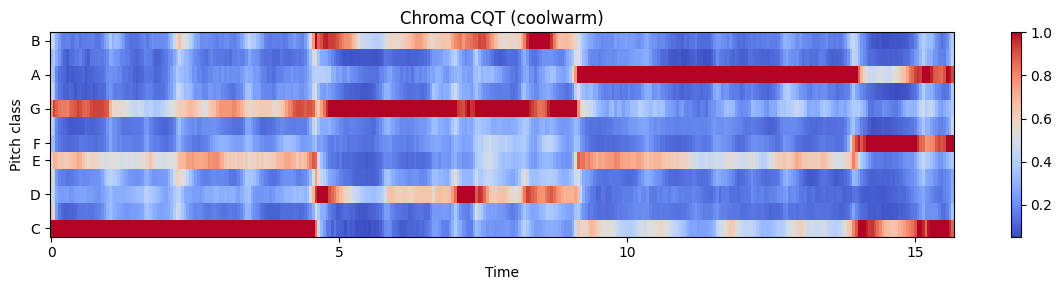

In [12]:
def build_final_chroma(path):
    '''WIP'''
    y, sr = librosa.load(path)
    y_trimmed, _ = librosa.effects.trim(y, top_db=10)
    return librosa.feature.chroma_cqt(y=y_trimmed, sr=sr)

final_chroma = build_final_chroma(output_path)
plot_chroma(final_chroma, 'CQT')